In [1]:
import numpy as np
from matplotlib import pyplot as pl
import os
import scipy.io.wavfile as wav

%matplotlib inline

In [2]:
# PATH = '/home/arthur/Projects/MLG_Labs/pw2/vowels/'
PATH = '/Users/faku99/HEIG/S6/MLG/labs/pw2/vowels/'

In [3]:
sample_rate_1, X_1 = wav.read(os.path.join(PATH, 'nafdlal.wav'))
sample_rate_2, X_2 = wav.read(os.path.join(PATH, 'nafdloo.wav'))

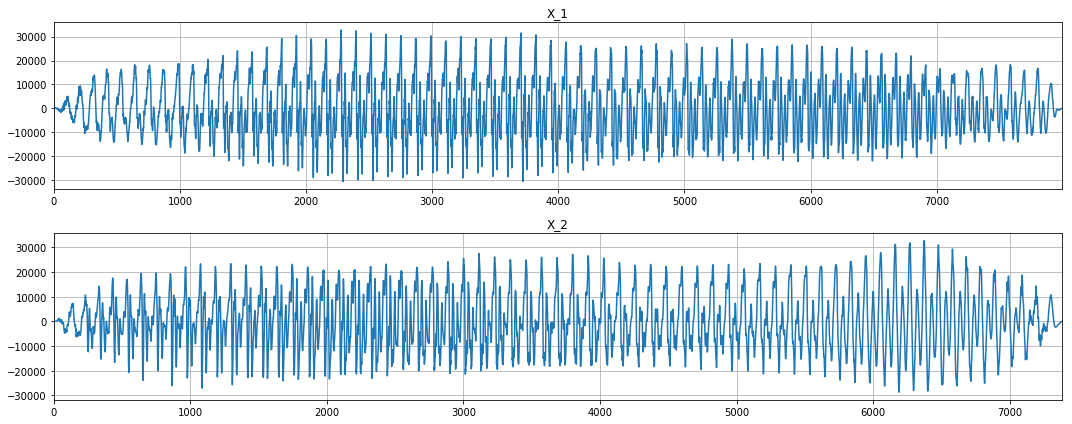

In [4]:
pl.figure(figsize=(15,6))
pl.subplot(2,1,1)
pl.plot(X_1)
pl.xlim(0, len(X_1))
pl.title('X_1')
pl.grid()
pl.subplot(2,1,2)
pl.plot(X_2)
pl.xlim(0, len(X_2))
pl.title('X_2')
pl.grid()
pl.tight_layout()

In [5]:
from python_speech_features import mfcc
import numpy
import mlp_backprop_momentum as mlp
import sys
from ipywidgets import interact, widgets

In [6]:
ceps_1 = mfcc(X_1, samplerate=sample_rate_1, nfft=1024, numcep=8)
ceps_2 = mfcc(X_2, samplerate=sample_rate_2, nfft=1024, numcep=8)

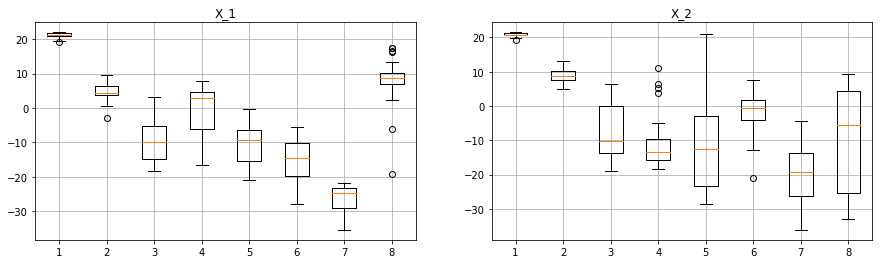

In [7]:
pl.figure(figsize=(15,4))
pl.subplot(1,2,1)
pl.boxplot(ceps_1)
pl.title('X_1')
pl.grid()
pl.subplot(1,2,2)
pl.boxplot(ceps_2)
pl.title('X_2')
pl.grid()

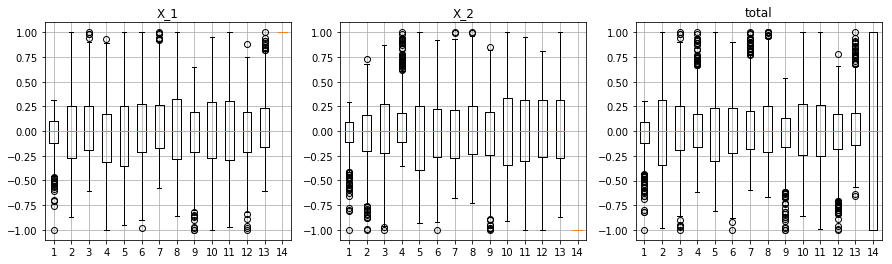

In [64]:
import os

def getFullDataSet(path, pop1, pop2):
    
    files0 = []
    files1 = []
    medians0 = []
    medians1 = []
    maxs0 = []
    maxs1 = []

    for i in os.listdir(path):
        if os.path.isfile(os.path.join(path,i)) and pop1 in i:
            files0.append(i)
        if os.path.isfile(os.path.join(path,i)) and pop2 in i:
            files1.append(i)

    sample_rate, X = wav.read(os.path.join(PATH, files0[0]))
    ceps0 = mfcc(X, samplerate=sample_rate, nfft=1024, numcep=13)

    for i in range(len(files0)-1):
        sample_rate, X = wav.read(os.path.join(PATH, files0[i+1]))
        ceps0 = np.concatenate((ceps0, mfcc(X, samplerate=sample_rate, nfft=1024, numcep=13)), axis=0)

    sample_rate, X = wav.read(os.path.join(PATH, files1[0]))
    ceps1 = mfcc(X, samplerate=sample_rate, nfft=1024, numcep=13)
    
    for i in range(len(files1)-1):
        sample_rate, X = wav.read(os.path.join(PATH, files1[i+1]))
        ceps1 = np.concatenate((ceps1, mfcc(X, samplerate=sample_rate, nfft=1024, numcep=13)), axis=0)
        
    ceps_total = np.concatenate((ceps0, ceps1), axis=0)

    medians = np.median(ceps_total, axis=0)
    ceps_total = np.subtract(ceps_total, medians)
    
    maxs = numpy.max(np.abs(ceps_total), axis=0)   
    mins = numpy.min(np.abs(ceps_total), axis=0)
    
    ceps_total = np.divide(ceps_total, maxs - mins)

    class0 = np.ones(len(ceps0)) 
    class1 = -1*np.ones(len(ceps1))
    
    class_total = np.concatenate((class0, class1), axis=0)
    
    ceps_total = np.concatenate((ceps_total, class_total[:, None]), axis=1)

    meds0 = np.median(ceps0, axis=0)
    ceps0 = np.subtract(ceps0, meds0)
    mins0 = np.min(np.abs(ceps0), axis=0)
    maxs0 = np.max(np.abs(ceps0), axis=0)

    meds1 = np.median(ceps1, axis=0)
    ceps1 = np.subtract(ceps1, meds1)
    mins1 = np.min(np.abs(ceps1), axis=0)
    maxs1 = np.max(np.abs(ceps1), axis=0)
    
    ceps0 = np.divide(ceps0, maxs0 - mins0)
    ceps1 = np.divide(ceps1, maxs1 - mins1)

    class0 = np.ones(len(ceps0))
    class1 = -1*np.ones(len(ceps1))
     
    ceps0 = np.concatenate((ceps0, np.array(class0)[:, None]), axis = 1)
    ceps1 = np.concatenate((ceps1, np.array(class1)[:, None]), axis = 1)

    #ceps_total = np.concatenate((ceps0, ceps1), axis=0)
    #return ceps_total
    return ceps0, ceps1, ceps_total

data0, data1, total = getFullDataSet(PATH, 'nam', 'sam')

pl.figure(figsize=(15,4))
pl.subplot(1,3,1)
pl.boxplot(data0)
pl.title('X_1')
pl.grid()

pl.subplot(1,3,2)
pl.boxplot(data1)
pl.title('X_2')
pl.grid()

pl.subplot(1,3,3)
pl.boxplot(total)
pl.title('total')
pl.grid()

In [66]:
def split_dataset(dataset, n_parts=5):
    n_rows = dataset.shape[0]
    index_all = np.arange(n_rows)
    np.random.shuffle(index_all)
    parts = []
    current_start = 0
    for p in np.arange(n_parts):
        current_end = current_start + int(np.floor(n_rows / (n_parts-p)))
        parts.append(dataset[index_all[current_start:current_end],:])
        n_rows -= current_end - current_start
        current_start = current_end
    return parts

def k_fold_cross_validation(nn, dataset, K=5, learning_rate=0.01, momentum=0.7, epochs=100):
    MSE_train_mean = 0.0
    MSE_test_mean = 0.0

    parts = split_dataset(dataset, K)
    
    for k in np.arange(K):
        nn.init_weights()
        
        training_parts = set(np.arange(K))
        training_parts.remove(k)
        dataset_train = np.concatenate([parts[i] for i in list(training_parts)])
        dataset_test = parts[k]

        input_data = dataset_train[:,0:nn.n_inputs]
        output_data = dataset_train[:,nn.n_inputs:(nn.n_inputs+nn.n_outputs)]
        input_data_test = dataset_test[:,0:nn.n_inputs]
        output_data_test = dataset_test[:,nn.n_inputs:(nn.n_inputs+nn.n_outputs)]
        
        MSE_train = nn.fit((input_data, output_data),
                            learning_rate=learning_rate, momentum=momentum, epochs=epochs)
        temp, _ = nn.compute_MSE((input_data, output_data))
        MSE_train_mean += temp
        temp, _ = nn.compute_MSE((input_data_test, output_data_test))
        MSE_test_mean += temp

    return (MSE_train_mean / K, MSE_test_mean / K)

ceps0, ceps1, manVswoman = getFullDataSet(PATH, 'naf', 'nam')

# Neural network parameters
N_NEURONS = 2

network = mlp.MLP([13, N_NEURONS, 1], 'tanh')
MSE_train, MSE_test = k_fold_cross_validation(network, manVswoman)
print('MSE_train: ' + str(MSE_train) + ', MSE_test: ', str(MSE_test))

MSE_train: 0.007969535202508217, MSE_test:  0.04465850634857392


IndexError: tuple index out of range

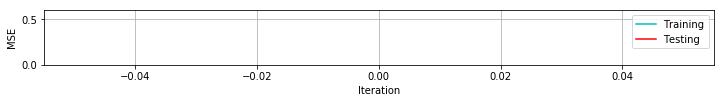

In [76]:
MAX_COL = 4
n_rows = np.ceil(MSE_train / MAX_COL)
pl.figure(figsize=(12, n_rows))
pl.subplot(1, 1, 1)
pl.plot(MSE_train, c='c', label='Training')
pl.plot(MSE_test, c='r', label='Testing')
pl.legend()
pl.ylim(0, 0.6)
pl.ylabel('MSE')
pl.xlabel('Iteration')
pl.grid()